In [125]:
import matplotlib.pyplot as plt
import pandas as pd
from os import path
import itertools as it

teapot_names = [
    '/home/aq85800/NewVolume/SpacetimeGaussians/output/techni_lite_noprior48/teapot+box+67mocap+48frames_20250326/loss_history.csv',
    '/home/aq85800/NewVolume/SpacetimeGaussians/output/techni_lite_noprior72/teapot+box+200mocap+72frames/loss_history.csv',
]
cloud_names = [
    '/home/aq85800/NewVolume/SpacetimeGaussians/output/techni_lite_noprior48/cloud+0transparent+paving+67mocap+48frames+20250319/loss_history.csv',
    '/home/aq85800/NewVolume/SpacetimeGaussians/output/techni_lite_noprior48/cloud+0transparent+paving+67mocap+48frames+single_camera/loss_history.csv',
    '/home/aq85800/NewVolume/SpacetimeGaussians/output/techni_lite_noprior48/cloud+0transparent+paving+67mocap+48frames+nograze/loss_history.csv',
    '/home/aq85800/NewVolume/SpacetimeGaussians/output/techni_lite_noprior48/cloud+0transparent+paving+67mocap+48frames+nograze+single_camera/loss_history.csv',
]

plot_tails = [5000, 1000]
tails_data_resolution = 10

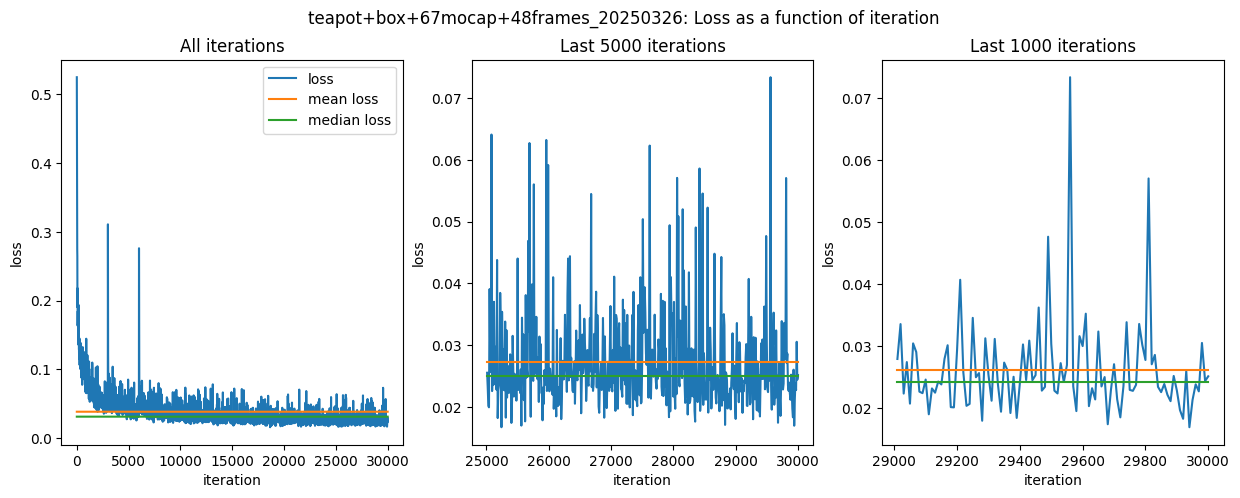

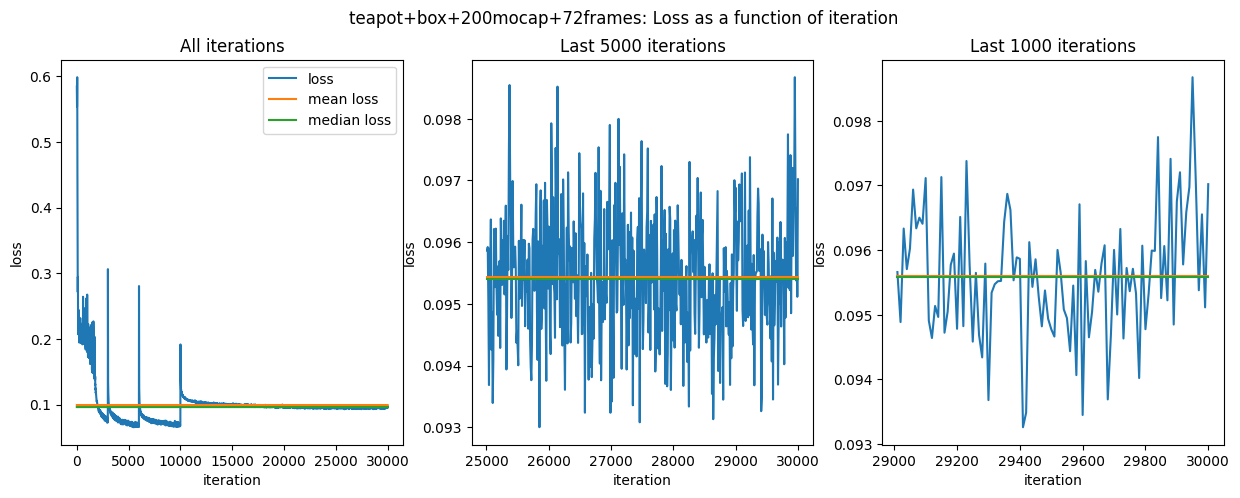

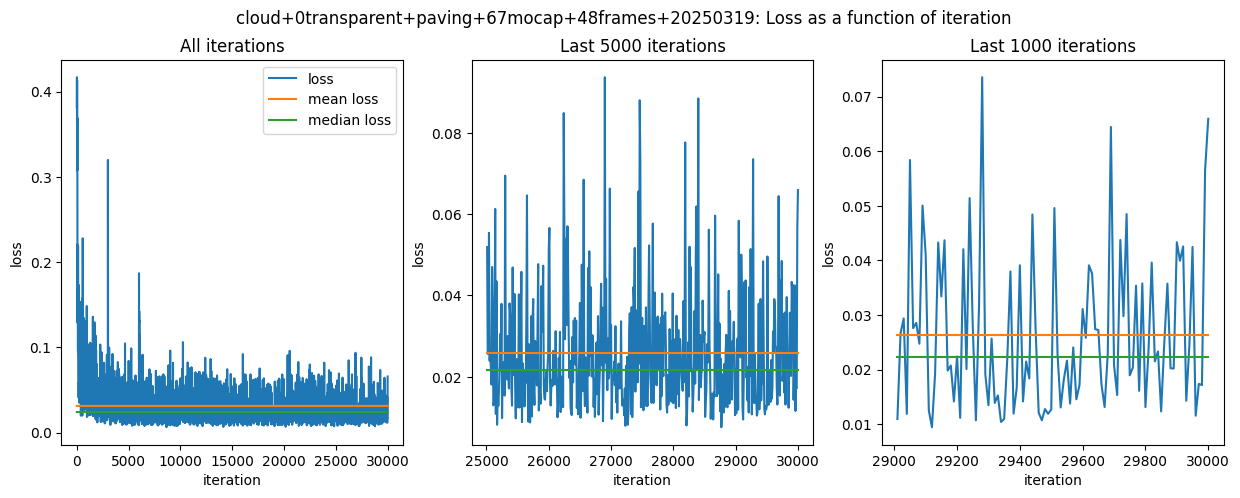

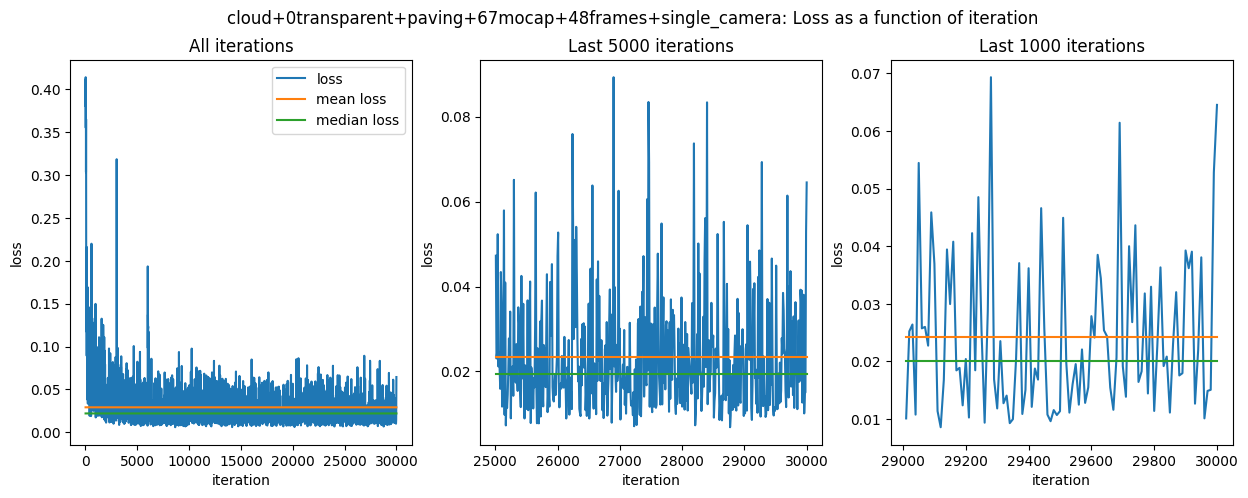

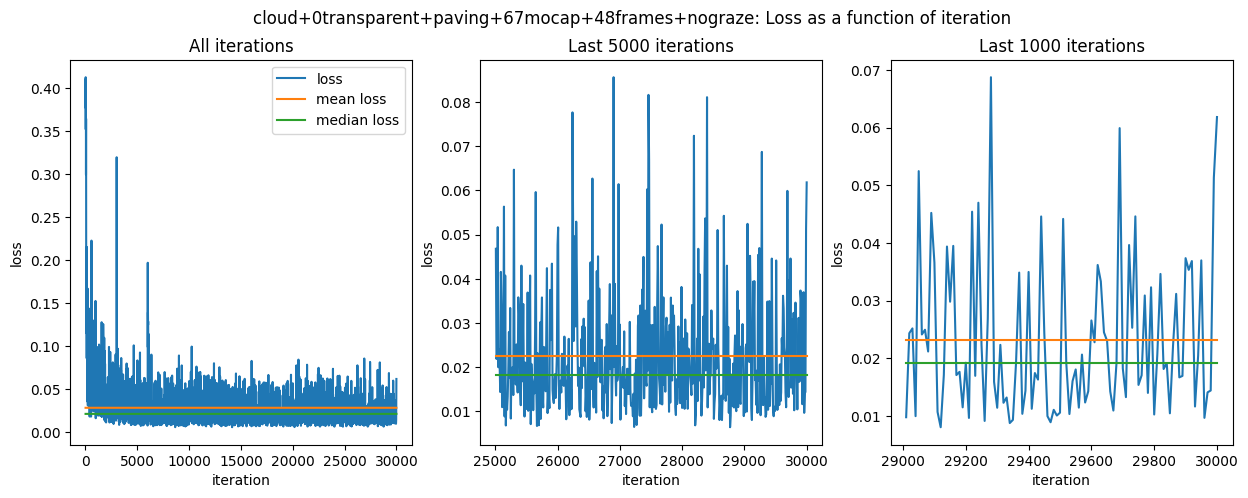

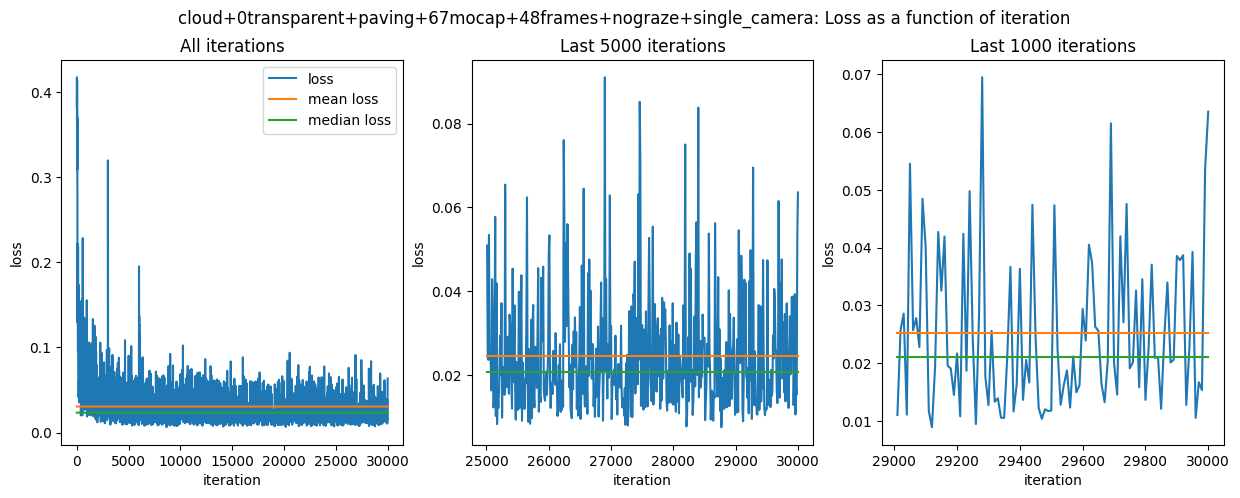

In [126]:
def plot_line(csv_file_name, color):
    try:
        with open(csv_file_name, 'r') as csv_file:
            data = pd.read_csv(csv_file, delimiter=' ')
    except FileNotFoundError:
        print(f"Could not open {csv_file_name}")
        return
    except pd.errors.EmptyDataError:
        print(f"Empty file {csv_file_name}")
        return

    fig, ax = plt.subplots(1, 1+len(plot_tails), figsize=(15, 5))
    ax[0].set_title('All iterations')
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('loss')
    ax[0].plot(data['iteration'], data['loss'], label="loss")
    ax[0].plot(data['iteration'], data['loss'].mean().repeat(len(data['iteration'])), label="mean loss")
    ax[0].plot(data['iteration'], data['loss'].median().repeat(len(data['iteration'])), label="median loss")
    ax[0].legend(['loss', 'mean loss', 'median loss'])
    for (i, tail) in enumerate(plot_tails):
        ax[i+1].set_title(f'Last {tail} iterations')
        ax[i+1].set_xlabel('iteration')
        ax[i+1].set_ylabel('loss')
        n_points = int(tail/tails_data_resolution)
        ax[i+1].plot(
            data['iteration'].tail(n_points), 
            data['loss'].tail(n_points))
        ax[i+1].plot(
            data['iteration'].tail(n_points), 
            data['loss'].tail(n_points).mean().repeat(n_points), label="mean loss")
        ax[i+1].plot(
            data['iteration'].tail(n_points), 
            data['loss'].tail(n_points).median().repeat(n_points), label="median loss")
    fig.suptitle(
        f"{csv_file_name.split('/')[-2]}: Loss as a function of iteration")
    fig.show()


colormap = plt.colormaps['tab10']
for csv_file_name in teapot_names:
    plot_line(csv_file_name, colormap(0/(2-1)))
for csv_file_name in cloud_names:
    plot_line(csv_file_name, colormap(1/(2-1)))

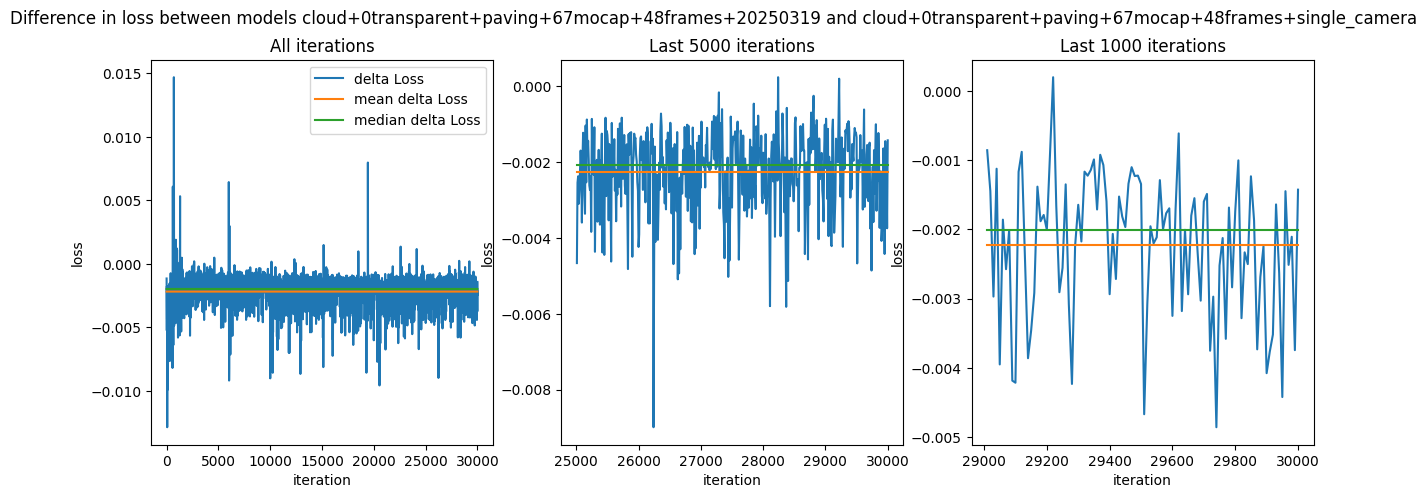

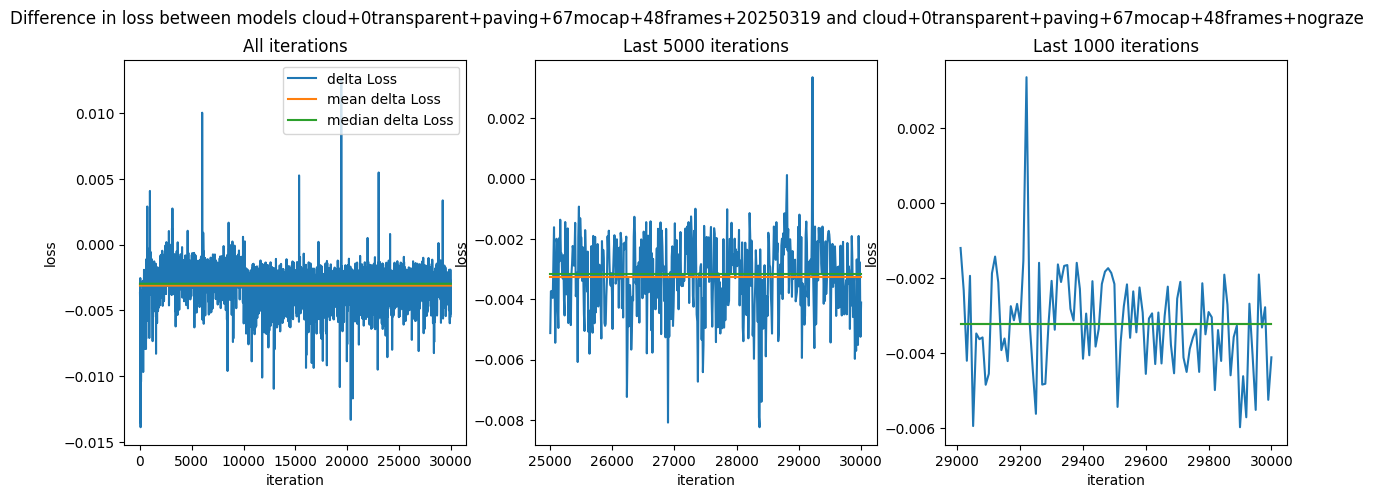

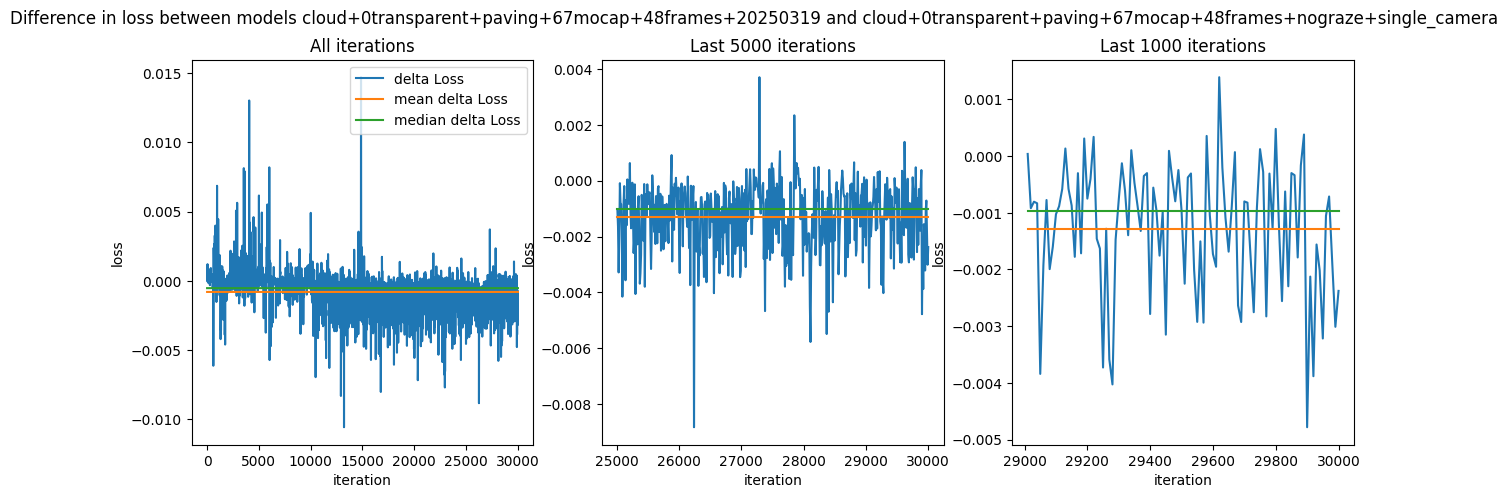

In [127]:
csv_files = [open(name, 'r') for name in cloud_names]
loss_data = [pd.read_csv(csv_file, delimiter=' ') for csv_file in csv_files]
for (n, name) in it.islice(enumerate(cloud_names), 1, None):
    difference = pd.DataFrame({
        "iteration": loss_data[n]['iteration'],
        "delta Loss": loss_data[n]['loss']-loss_data[0]["loss"]})
    fig, ax = plt.subplots(1, 1+len(plot_tails), figsize=(15, 5))
    fig.suptitle(f'Difference in loss between models {cloud_names[0].split('/')[-2]} and {cloud_names[n].split("/")[-2]}')
    ax[0].set_title(f'All iterations')
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('loss')
    ax[0].plot(
        difference['iteration'],
        difference['delta Loss'],
        label = 'delta Loss')
    ax[0].plot(
        difference['iteration'],
        difference['delta Loss'].mean().repeat(len(difference['iteration'])),
        label = 'mean delta Loss')
    ax[0].plot(
        difference['iteration'],
        difference['delta Loss'].median().repeat(len(difference['iteration'])),
        label = 'median delta Loss')
    ax[0].legend(['delta Loss', 'mean delta Loss', 'median delta Loss'])
    for (i, tail) in enumerate(plot_tails):
        ax[i+1].set_title(f'Last {tail} iterations')
        ax[i+1].set_xlabel('iteration')
        ax[i+1].set_ylabel('loss')
        n_points = int(tail/tails_data_resolution)
        ax[i+1].plot(
            difference['iteration'].tail(n_points),
            difference['delta Loss'].tail(n_points),
            label = 'delta Loss')
        ax[i+1].plot(
            difference['iteration'].tail(n_points),
            difference['delta Loss'].tail(n_points).mean().repeat(n_points),
            label = 'mean delta Loss')
        ax[i+1].plot(
            difference['iteration'].tail(n_points),
            difference['delta Loss'].tail(n_points).median().repeat(n_points),
            label = 'median delta Loss')
    fig.show()